In [77]:
import pandas as pd
from io import StringIO

def parse_html_file(file_path):
    """
    Read an HTML file and parse its table content into a pandas DataFrame
    
    Parameters:
    file_path (str): Path to the HTML file
    
    Returns:
    pandas.DataFrame: Parsed table data
    """
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Read HTML content using pandas
    df = pd.read_html(StringIO(html_content))[0]
    
    # Clean up column names
    df.columns = df.columns.str.strip()
    
    # Replace empty strings with NaN
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    
    # Convert wage column to numeric, removing '£' and 'p/w'
    if 'Wage' in df.columns:
        df['Wage'] = df['Wage'].str.replace('£', '').str.replace(' p/w', '').str.replace(',', '')
        df['Wage'] = pd.to_numeric(df['Wage'], errors='coerce')
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Age', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 'Ant', 
                      'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 'Fin',
                      'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 'OtB',
                      'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Thr',
                      'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

df = parse_html_file("wage_player_export.html")
df = df.drop(columns=["Inf"])

In [78]:
print(df[df['Name'] == "David Raya"])
print(df.columns)

           Name Position  Nat  Age     Club   Wage       Personality  \
437  David Raya       GK  ESP   27  Arsenal  75000  Fairly Ambitious   

      Left Foot   Right Foot  Com  ...  Wor  Cor  Fre  L Th  Pen  Nat.1  \
437  Reasonable  Very Strong   14  ...   13    1    2     3    5     16   

     Height                  Division  Injury Risk    Expires  
437    6'0"  English Premier Division    Increased  30/6/2024  

[1 rows x 60 columns]
Index(['Name', 'Position', 'Nat', 'Age', 'Club', 'Wage', 'Personality',
       'Left Foot', 'Right Foot', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer',
       'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec',
       'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr',
       'Lon', 'Mar', 'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck',
       'Tea', 'Tec', 'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen',
       'Nat.1', 'Height', 'Division', 'Injury Risk', 'Expires'],
      dtype='object')


In [79]:
# Positional features
#df["is_gk"] = df["Position"].str.contains(r"GK", regex=True).astype(int)
df["is_cb"] = df["Position"].str.contains(r"D \((C|LC|RC|RLC)\)", regex=True).astype(int)
df["is_fb"] = df["Position"].str.contains(r"D \([LR]+[C]?\)|WB", regex=True).astype(int)
df["is_dm"] = df["Position"].str.contains(r"DM", regex=True).astype(int)
df["is_cm"] = df["Position"].str.contains(r"M \([LR]*C[LR]*\)", regex=True).astype(int)
df["is_w"] = df["Position"].str.contains(r"(M|AM|M/AM) \([LR]+\)", regex=True).astype(int)
df["is_am"] = df["Position"].str.contains(r"AM \([LR]*C[LR]*\)", regex=True).astype(int)
df["is_st"] = df["Position"].str.contains(r"ST", regex=True).astype(int)
df["num_pos"] = df[["is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st"]].sum(axis=1)

# Foot features
df["strong_left"] = df["Left Foot"].isin(["Strong", "Fairly Strong", "Very Strong"]).astype(int)
df["strong_right"] = df["Right Foot"].isin(["Strong", "Fairly Strong", "Very Strong"]).astype(int)

# Contract feature
df["Expires"] = pd.to_datetime(df["Expires"])
reference_date = pd.to_datetime("2023-07-01")
df["days_until_expiry"] = (df["Expires"] - reference_date).dt.days

# Height feature
def height_to_cm(height):
    feet, inches = map(int, height.replace('"', '').split("'"))
    return (feet * 30.48) + (inches * 2.54)

df['height_cm'] = df['Height'].apply(height_to_cm)

df = df[~df['Position'].str.contains('GK', na=False)] # remove GKs

C:\Users\Owner\AppData\Local\Temp\ipykernel_15328\117506809.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["is_cb"] = df["Position"].str.contains(r"D \((C|LC|RC|RLC)\)", regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15328\117506809.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["is_w"] = df["Position"].str.contains(r"(M|AM|M/AM) \([LR]+\)", regex=True).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15328\117506809.py:17: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Expires"] = pd.to_datetime(df["Expires"])


In [80]:
reg_cols = [["Wage", "is_cb", "is_fb", "is_dm", "is_cm", "is_w", "is_am", "is_st", "num_pos", "Age",
              "strong_left", "strong_right", "days_until_expiry", "height_cm", "Club", "Division", "Nat", 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer',
       'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec',
       'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr',
       'Lon', 'Mar', 'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck',
       'Tea', 'Tec', 'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']]

reg_df = pd.DataFrame()



reg_df = df[~df['Position'].str.contains('GK', na=False)][reg_cols[0]].copy() # remove goalkeepers

reg_df = pd.get_dummies(reg_df, columns=['Nat', 'Club', 'Division'])


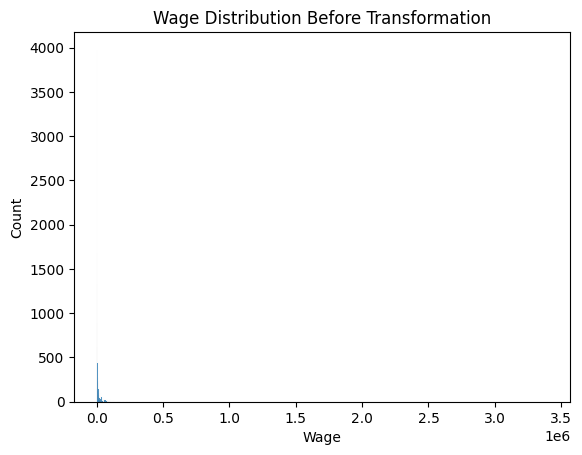

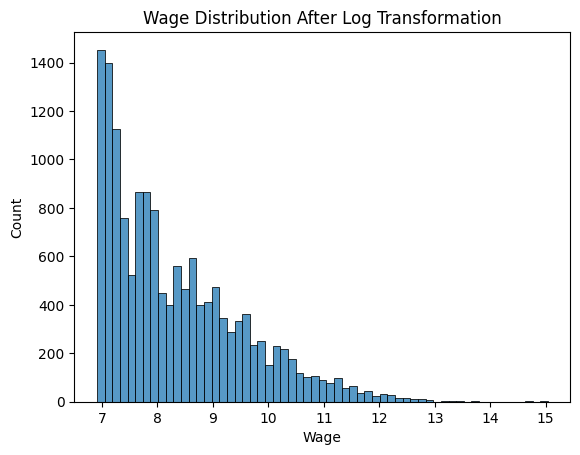

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Before transformation
sns.histplot(df['Wage'])
plt.title('Wage Distribution Before Transformation')
plt.show()

# After transformation
sns.histplot(np.log1p(df['Wage']))
plt.title('Wage Distribution After Log Transformation')
plt.show()

In [82]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb
import numpy as np
import pandas as pd

# Prepare data
X = reg_df.drop('Wage', axis=1)  # Features
y = np.log1p(reg_df['Wage'])     # Log-transformed target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Initialize model with the optimized parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.02,    
    max_depth=3,           
    subsample=0.7,         
    colsample_bytree=0.7,  
    min_child_weight=4,    
    gamma=1,               
    reg_alpha=0.1,         
    reg_lambda=1,          
    random_state=42    
)

# Simple fit without early stopping
model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Get predictions for both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Transform predictions back to original scale
y_train_original = np.expm1(y_train)
y_train_pred_original = np.expm1(y_train_pred)
y_test_original = np.expm1(y_test)
y_test_pred_original = np.expm1(y_test_pred)

print("Model Performance and Overfitting Analysis:")
print("-" * 50)

# Log scale metrics
print("Log Scale Metrics:")
train_r2_log = r2_score(y_train, y_train_pred)
test_r2_log = r2_score(y_test, y_test_pred)
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {train_r2_log:.3f}")
print(f"Test R²: {test_r2_log:.3f}")
print(f"R² Difference: {train_r2_log - test_r2_log:.3f}")
print(f"\nTraining RMSE: {train_rmse_log:.3f}")
print(f"Test RMSE: {test_rmse_log:.3f}")
print(f"RMSE Difference: {test_rmse_log - train_rmse_log:.3f}")

# Original scale metrics
print("\nOriginal Scale Metrics:")
train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred_original)
test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original)
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
test_mae = mean_absolute_error(y_test_original, y_test_pred_original)

print(f"Training MAPE: {train_mape:.1%}")
print(f"Test MAPE: {test_mape:.1%}")
print(f"MAPE Difference: {test_mape - train_mape:.1%}")
print(f"\nTraining MAE: £{train_mae:,.2f}")
print(f"Test MAE: £{test_mae:,.2f}")
print(f"MAE Difference: £{test_mae - train_mae:,.2f}")

# Error distributions
train_errors = abs(y_train_original - y_train_pred_original)
test_errors = abs(y_test_original - y_test_pred_original)

print('\nError Distribution (Original Scale):')
print("Training Errors:")
print(f'25th percentile: £{np.percentile(train_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(train_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(train_errors, 75):,.2f}')
print("\nTest Errors:")
print(f'25th percentile: £{np.percentile(test_errors, 25):,.2f}')
print(f'Median error: £{np.percentile(test_errors, 50):,.2f}')
print(f'75th percentile: £{np.percentile(test_errors, 75):,.2f}')

# Percentage error distributions
train_percent_errors = abs((y_train_original - y_train_pred_original) / y_train_original * 100)
test_percent_errors = abs((y_test_original - y_test_pred_original) / y_test_original * 100)

print('\nPercentage Error Distribution:')
print("Training Errors:")
print(f'25th percentile: {np.percentile(train_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(train_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(train_percent_errors, 75):.1f}%')
print("\nTest Errors:")
print(f'25th percentile: {np.percentile(test_percent_errors, 25):.1f}%')
print(f'Median error: {np.percentile(test_percent_errors, 50):.1f}%')
print(f'75th percentile: {np.percentile(test_percent_errors, 75):.1f}%')

# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(importance_df.sort_values('importance', ascending=False).head(10))

# Cross-validation
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='r2'
)
print(f"\nCross-validation Results:")
print(f"R² scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f}")
print(f"Std R²: {cv_scores.std():.3f}")

# Error by wage brackets
train_brackets = pd.qcut(y_train_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
test_brackets = pd.qcut(y_test_original, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

train_error_by_bracket = pd.DataFrame({
    'Actual': y_train_original,
    'Predicted': y_train_pred_original,
    'Bracket': train_brackets
})
test_error_by_bracket = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_test_pred_original,
    'Bracket': test_brackets
})

train_error_by_bracket['Percentage_Error'] = abs(train_error_by_bracket['Predicted'] - train_error_by_bracket['Actual']) / train_error_by_bracket['Actual'] * 100
test_error_by_bracket['Percentage_Error'] = abs(test_error_by_bracket['Predicted'] - test_error_by_bracket['Actual']) / test_error_by_bracket['Actual'] * 100

print("\nMAPE by Wage Bracket:")
print("Training:")
print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
print("\nTest:")
print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))

Model Performance and Overfitting Analysis:
--------------------------------------------------
Log Scale Metrics:
Training R²: 0.807
Test R²: 0.784
R² Difference: 0.024

Training RMSE: 0.532
Test RMSE: 0.563
RMSE Difference: 0.031

Original Scale Metrics:
Training MAPE: 44.2%
Test MAPE: 46.2%
MAPE Difference: 2.0%

Training MAE: £5,283.06
Test MAE: £5,537.27
MAE Difference: £254.21

Error Distribution (Original Scale):
Training Errors:
25th percentile: £405.03
Median error: £1,004.58
75th percentile: £3,027.42

Test Errors:
25th percentile: £439.26
Median error: £1,077.10
75th percentile: £3,311.12

Percentage Error Distribution:
Training Errors:
25th percentile: 15.7%
Median error: 33.4%
75th percentile: 56.7%

Test Errors:
25th percentile: 16.3%
Median error: 34.0%
75th percentile: 58.2%

Top 10 Most Important Features:
                                feature  importance
21                                  Ant    0.052542
26                                  Cmp    0.049631
46        

C:\Users\Owner\AppData\Local\Temp\ipykernel_15328\3783277645.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))
C:\Users\Owner\AppData\Local\Temp\ipykernel_15328\3783277645.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(test_error_by_bracket.groupby('Bracket')['Percentage_Error'].mean().round(1))


In [85]:

player = 'Cristiano Ronaldo'
player_data = df[df['Name'] == player ]

if len(player_data) == 0:
    print("Player not found in dataset")
else:
    # Create a single row dataframe with exactly the same features as X (training data)
    player_features = pd.DataFrame(columns=X.columns)
    player_features.loc[0] = 0  # Initialize with zeros
    
    # Fill in the numerical/boolean columns
    numeric_cols = ['is_cb', 'is_fb', 'is_dm', 'is_cm', 'is_w', 'is_am', 'is_st', 
                   'num_pos', 'Age', 'strong_left', 'strong_right', 'days_until_expiry', 
                   'height_cm', 'Com', 'Ecc', 'Pun', '1v1', 'Acc', 'Aer', 'Agg', 'Agi', 
                   'Ant', 'Bal', 'Bra', 'Cmd', 'Cnt', 'Cmp', 'Cro', 'Dec', 'Det', 'Dri', 
                   'Fin', 'Fir', 'Fla', 'Han', 'Hea', 'Jum', 'Kic', 'Ldr', 'Lon', 'Mar', 
                   'OtB', 'Pac', 'Pas', 'Pos', 'Ref', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 
                   'Thr', 'TRO', 'Vis', 'Wor', 'Cor', 'Fre', 'L Th', 'Pen']
    
    for col in numeric_cols:
        if col in player_data.columns and col in player_features.columns:
            player_features[col] = player_data[col].values[0]
    
    # Handle categorical columns (one-hot encoded)
    # Nationality
    nat_col = f"Nat_{player_data['Nat'].values[0]}"
    if nat_col in player_features.columns:
        player_features[nat_col] = 1
    
    # Club
    club_col = f"Club_{player_data['Club'].values[0]}"
    if club_col in player_features.columns:
        player_features[club_col] = 1
    
    # Division
    div_col = f"Division_{player_data['Division'].values[0]}"
    if div_col in player_features.columns:
        player_features[div_col] = 1
    
    # Make prediction
    pred_log = model.predict(player_features)
    predicted_wage = np.expm1(pred_log[0])
    actual_wage = player_data['Wage'].values[0]
    
    print(f"\nPrediction Results for {player}:")
    print("-" * 50)
    print(f"Predicted Wage: £{predicted_wage:,.2f} per week")
    print(f"Actual Wage: £{actual_wage:,.2f} per week")
    print(f"Prediction Error: £{abs(predicted_wage - actual_wage):,.2f}")
    print(f"Percentage Error: {abs(predicted_wage - actual_wage) / actual_wage * 100:.1f}%")
    
    # Show top contributing features
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_,
        'value': player_features.iloc[0].values
    })
    
    # Calculate contribution (importance * actual value)
    feature_importance['contribution'] = feature_importance['importance'] * abs(feature_importance['value'])
    
    print(f"\nTop 10 Contributing Features to {player}'s Prediction:")
    print(feature_importance.sort_values('contribution', ascending=False).head(10)[['feature', 'value', 'importance', 'contribution']])


Prediction Results for Cristiano Ronaldo:
--------------------------------------------------
Predicted Wage: £564,388.94 per week
Actual Wage: £3,400,000.00 per week
Prediction Error: £2,835,611.06
Percentage Error: 83.4%

Top 10 Contributing Features to Cristiano Ronaldo's Prediction:
              feature  value  importance  contribution
11  days_until_expiry  730.0    0.025139     18.351714
21                Ant   17.0    0.052542      0.893216
26                Cmp   15.0    0.049631      0.744462
50                Tec   17.0    0.040025      0.680427
32                Fir   15.0    0.039206      0.588092
46                Sta   13.0    0.041781      0.543148
22                Bal   13.0    0.038821      0.504676
42                Pac   13.0    0.031017      0.403226
41                OtB   18.0    0.015980      0.287640
23                Bra   13.0    0.021903      0.284744


In [86]:
def analyze_wages(df, X, y, model, league_filter=None, club_filter=None, min_wage=0, min_age=0, top_n=15):
    """
    Analyze player wages with optional filtering by league or club
    
    Parameters:
    -----------
    df: DataFrame with player info
    X: Feature matrix
    y: Target wages (log scale)
    model: Trained model
    league_filter: Optional league/division to filter by
    club_filter: Optional club to filter by
    min_wage: Minimum actual wage to consider
    top_n: Number of players to show in each category
    """
    # Get predictions for all players
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y)
    
    # Create analysis dataframe
    wage_analysis = pd.DataFrame({
        'Name': df['Name'],
        'Club': df['Club'],
        'Division': df['Division'],
        'Age': df['Age'],
        'Actual_Wage': y_actual,
        'Predicted_Wage': y_pred,
        'Wage_Difference': y_actual - y_pred,
        'Percentage_Difference': ((y_actual - y_pred) / y_pred) * 100
    })
    
    # Apply filters
    if league_filter:
        wage_analysis = wage_analysis[wage_analysis['Division'] == league_filter]
    if club_filter:
        wage_analysis = wage_analysis[wage_analysis['Club'] == club_filter]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Actual_Wage'] >= min_wage]
    if min_wage > 0:
        wage_analysis = wage_analysis[wage_analysis['Age'] >= min_age]
    
    if len(wage_analysis) == 0:
        print("No players found matching the specified filters.")
        return
    
    # Calculate value metrics
    wage_analysis['Overpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: max(x, 0))
    wage_analysis['Underpaid_Amount'] = wage_analysis['Wage_Difference'].apply(lambda x: min(x, 0))
    
    # Print filter information
    print("\nAnalysis Parameters:")
    print("-" * 50)
    if league_filter:
        print(f"League: {league_filter}")
    if club_filter:
        print(f"Club: {club_filter}")
    if min_wage > 0:
        print(f"Minimum Wage: £{min_wage:,.2f}")
    print(f"Number of players analyzed: {len(wage_analysis)}")
    print()
    
    # Find most overpaid players
    print(f"\nTop {top_n} Most Overpaid Players:")
    print("-" * 50)
    overpaid = wage_analysis.nlargest(top_n, 'Percentage_Difference')
    for _, player in overpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Overpaid by: £{player['Wage_Difference']:,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Find most underpaid players
    print(f"\nTop {top_n} Most Underpaid Players:")
    print("-" * 50)
    underpaid = wage_analysis.nsmallest(top_n, 'Percentage_Difference')
    for _, player in underpaid.iterrows():
        print(f"{player['Name']} ({player['Club']}):")
        print(f"  Age: {player['Age']}")
        print(f"  Actual Wage: £{player['Actual_Wage']:,.2f}")
        print(f"  Predicted Wage: £{player['Predicted_Wage']:,.2f}")
        print(f"  Underpaid by: £{abs(player['Wage_Difference']):,.2f} ({player['Percentage_Difference']:.1f}%)")
        print()
    
    # Summary statistics
    print("\nWage Analysis Summary:")
    print("-" * 50)
    print(f"Average Actual Wage: £{wage_analysis['Actual_Wage'].mean():,.2f}")
    print(f"Average Predicted Wage: £{wage_analysis['Predicted_Wage'].mean():,.2f}")
    print(f"Total Overpaid Amount: £{wage_analysis['Overpaid_Amount'].sum():,.2f}")
    print(f"Total Underpaid Amount: £{abs(wage_analysis['Underpaid_Amount'].sum()):,.2f}")
    print(f"Average Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).mean():,.2f}")
    print(f"Median Absolute Wage Difference: £{abs(wage_analysis['Wage_Difference']).median():,.2f}")
    
    return wage_analysis

premier_league_analysis = analyze_wages(
    df, X, y, model, 
    #league_filter="English Premier Division",
    min_wage=50000,
    min_age=21,
    club_filter="Arsenal",
)


Analysis Parameters:
--------------------------------------------------
Club: Arsenal
Minimum Wage: £50,000.00
Number of players analyzed: 22


Top 15 Most Overpaid Players:
--------------------------------------------------
Cédric (Arsenal):
  Age: 31
  Actual Wage: £65,000.00
  Predicted Wage: £29,113.78
  Overpaid by: £35,886.22 (123.3%)

Kai Havertz (Arsenal):
  Age: 24
  Actual Wage: £220,000.00
  Predicted Wage: £106,059.60
  Overpaid by: £113,940.40 (107.4%)

Jakub Kiwior (Arsenal):
  Age: 23
  Actual Wage: £58,000.00
  Predicted Wage: £48,255.90
  Overpaid by: £9,744.10 (20.2%)

Reiss Nelson (Arsenal):
  Age: 23
  Actual Wage: £90,000.00
  Predicted Wage: £78,891.90
  Overpaid by: £11,108.10 (14.1%)

Takehiro Tomiyasu (Arsenal):
  Age: 24
  Actual Wage: £65,000.00
  Predicted Wage: £58,602.57
  Overpaid by: £6,397.43 (10.9%)

Gabriel Martinelli (Arsenal):
  Age: 22
  Actual Wage: £200,000.00
  Predicted Wage: £181,535.14
  Overpaid by: £18,464.86 (10.2%)

Jorginho (Arsenal):
 